# Uber market demand prediction using ARIMA

Market demand plays a crucial part in the marketing strategy of any company. Forecasting such demand becomes crucial when the market is filled with competition, and a small mismatch in supply and demand can lead to a customer switching to another service provider.

In this notebook we look at a classical algorithm(ARIMA) which can be used to predict the demand for user trips in the upcoming week for a particular location. Particularly, we will be utilizing Uber's 2014 user trips data of New York city, to accomplish the same.

The dataset can be found on kaggle.com(https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city)

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

First we upload our data-set into a single data-frame:

In [2]:
#Preparing the uber 2014 main dataset
def prepare_2014_df():
    
    #Loading datasets
    uber_2014_apr=pd.read_csv('uber-raw-data-apr14.csv',header=0)
    uber_2014_may=pd.read_csv('uber-raw-data-may14.csv',header=0)
    uber_2014_jun=pd.read_csv('uber-raw-data-jun14.csv',header=0)
    uber_2014_jul=pd.read_csv('uber-raw-data-jul14.csv',header=0)
    uber_2014_aug=pd.read_csv('uber-raw-data-aug14.csv',header=0)
    uber_2014_sep=pd.read_csv('uber-raw-data-sep14.csv',header=0)
    
    #Merging
    df = uber_2014_apr.append([uber_2014_may,uber_2014_jun,uber_2014_jul,uber_2014_aug,uber_2014_sep], ignore_index=True)
    
    #returning merged dataframe
    return df

#Uber 2014 dataset
uber_2014_master = prepare_2014_df()
uber_2014_master.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


Next, we prepare the data-frame so that it is in a time-series format, which can then be utilized for modelling.
Since we are only looking at a basic time-series forecast model, we will only be utilizing the Date/Time column for now.

I plan to predict the demand at a day level and hence we will be resampling the data at a day level. However deping on the need, we can sample the data at different levels(Hour,Month,Year etc.)

In [5]:
# Feature Engineering
def create_day_series(df):
    
    # Grouping by Date/Time to calculate number of trips
    day_df = pd.Series(df.groupby(['Date/Time']).size())
    # setting Date/Time as index
    day_df.index = pd.DatetimeIndex(day_df.index)
    # Resampling to daily trips
    day_df = day_df.resample('1D').apply(np.sum)
    
    return day_df

day_df_2014 = create_day_series(uber_2014_master)
day_df_2014.head()

Date/Time
2014-04-01    14546
2014-04-02    17474
2014-04-03    20701
2014-04-04    26714
2014-04-05    19521
Freq: D, dtype: int64

Now that we have the time-series data-frame ready, we can look into some initial visualizations of the data to decide our parameters for the ARIMA model

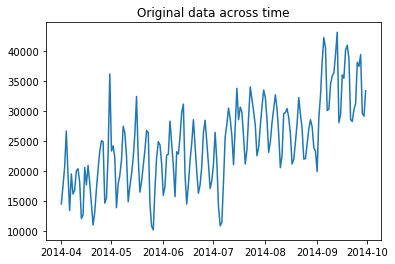

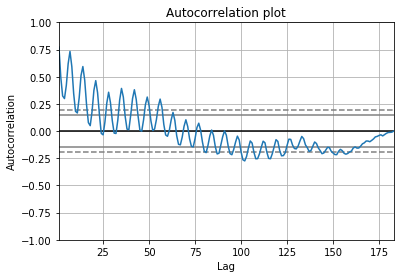

In [22]:
#Checking trend and autocorrelation
def initial_plots(time_series):

    #Original timeseries plot
    plt.figure(1)
    plt.plot(time_series)
    plt.title('Original data across time')
    #Autocorrelation plot
    plt.figure(2)
    autocorrelation_plot(time_series)
    plt.title('Autocorrelation plot')
    plt.show()
    
initial_plots(day_df_2014)

Looking at the original data, we see that there is a clear trend across time, hence a differencing of 1 or more would be required to make the time-series stationary.

From the autocorrelation plot, we see that there is a peak every 7 days, this suggests that a AR parameter of 7 should work well.

AIC = 3480.53
BIC = 3509.37


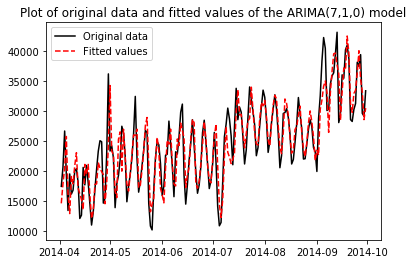

In [20]:
#fitting ARIMA model on dataset
def ARIMA_call(time_series,p,d,q):    
    
    #fitting the model
    ARIMA_model = ARIMA(time_series.astype(float), order=(p,d,q))
    ARIMA_model_fit = ARIMA_model.fit(disp=0)
    print ('AIC = {}'.format(np.round(ARIMA_model_fit.aic,2)))
    print ('BIC = {}'.format(np.round(ARIMA_model_fit.bic,2)))
    fitted_values = ARIMA_model_fit.predict(1,len(time_series)-1,typ='levels') #Index starts at 1 as differencing is in effect
    
    #Plotting
    plt.figure(3)
    plt.title('Plot of original data and fitted values of the ARIMA({},{},{}) model'.format(p,d,q))
    plt.plot(time_series[1:],'k-',label='Original data') #Plotting from index of 1 as differencing is in effect
    plt.plot(fitted_values,'r--',label='Fitted values')
    plt.legend()
    plt.show()
    
    #returning the fitted model and values
    return ARIMA_model_fit,fitted_values

fitted_model,fitted_values = ARIMA_call(day_df_2014,7,1,0)

I have chosen an ARIMA(7,1,0) model for this dataset.

The model was chosen after iterating through different AR,I, and MA values(represented by p,d,q respectively in the ARIMA_call).
The 7,1,0 parameters gives the lowest AIC and BIC scores for this time-series.

Now, that we have the fitted model we can go ahead and predict the demand for the upcoming days.

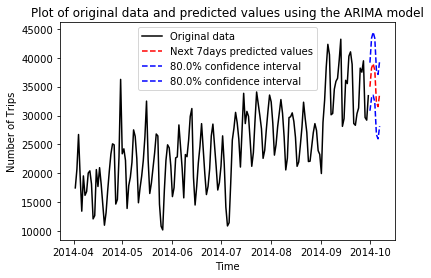

In [23]:
#Predicting values using the fitted model
def predict(df,fitted_model,n_days,conf):
    
    #Predicting
    values = pd.DataFrame(fitted_model.forecast(steps=n_days,alpha=(1-conf))[0],columns=['Prediction'])
    values.index = pd.date_range(df.index.max()+1,periods=n_days)
    conf_int = pd.DataFrame(fitted_model.forecast(steps=n_days,alpha=(1-conf))[2],columns=['Conf_int_lower_lim','Conf_int_upper_lim'])
    conf_int.index = pd.date_range(df.index.max()+1,periods=n_days)
    ARIMA_prediction = pd.merge(values,conf_int,left_index=True,right_index=True)
    
    #Plotting
    plt.figure(4)
    plt.title('Plot of original data and predicted values using the ARIMA model')
    plt.xlabel('Time')
    plt.ylabel('Number of Trips')
    plt.plot(df[1:],'k-', label='Original data')
    plt.plot(values,'r--', label='Next {}days predicted values'.format(n_days))
    plt.plot(conf_int,'b--', label='{}% confidence interval'.format(round(conf*100)))
    plt.legend()
    plt.show()
    
    #Returning predicitons
    return ARIMA_prediction

#Predicting the values and builing an 80% confidence interval
prediction = predict(day_df_2014,fitted_model,7,0.80)

As with any prediction, there is uncertainity associated with the result. However, the 80% confidence interval across the predicted values shows us that we are 80% confident that we have found an interval which contains the actual predicted values of the time-series.

Thus using this simple classical ARIMA model we can utilize the forecasted data to plan and alter our marketing strategy for the upcoming week(or any timeframe upon which predictions are to be made) in any location.

In this example, I have just used the complete dataset to forecast the demand, however we need not restrict ourselves to this level. We can split the data-set based on location and obtain forecasts for different pick-up zones in NYC(which would add even more value towards our predictions).